In [1]:
import requests
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
# download the dataset - a onetime task
url = "https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/0e7a9b0a5d22642a06d3d5b9bcbad9890c8ee534/iris.csv"
df = pd.read_csv(url)
df.to_csv('iris.csv', index=False)
df.head()

In [2]:
url = "iris.csv"
df = pd.read_csv(url)
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
df = df.replace({"species": {"setosa": 0, "versicolor": 1, "virginica": 2}})
df.head()

C:\Users\berek\AppData\Local\Temp\ipykernel_7740\609982642.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({"species": {"setosa": 0, "versicolor": 1, "virginica": 2}})


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [4]:
X = df.drop('species', axis=1).values
y = df['species'].values
print(X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(150, 4)
(150,)
torch.Size([120, 4])
torch.Size([30, 4])
torch.Size([120])
torch.Size([30])


In [35]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(4, 20, bias=False),
            nn.BatchNorm1d(20),
            nn.GELU(),
            nn.Linear(20, 32, bias=False),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.Linear(32, 3, bias=False)
        )

    def forward(self, x):
        return self.layers(x)

    def train(self, X_train, y_train, num_epochs):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=0.01)
        train_losses = []
        for epoch in range(num_epochs):
            optimizer.zero_grad()
            y_pred = self.forward(X_train)
            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()
            if epoch == 0 or epoch % 25 == 24:
                print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")
            train_losses.append(loss.item())
        return train_losses


In [36]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else 'cpu'
model = Model().to(device)
num_epochs = 100
train_losses = model.train(X_train, y_train, num_epochs)


Epoch 1/100, Loss: 1.198500394821167
Epoch 25/100, Loss: 0.05635455995798111
Epoch 50/100, Loss: 0.04241907596588135
Epoch 75/100, Loss: 0.02974284067749977
Epoch 100/100, Loss: 0.017952797934412956


In [19]:
print(f"Model structure: \n{model}")
print(f"\nModel parameters:")
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values: \n{param[:2]} \n")

Model structure: 
Model(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=20, bias=False)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=32, bias=False)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=3, bias=False)
  )
)

Model parameters:
Layer: layers.0.weight | Size: torch.Size([20, 4]) | Values: 
tensor([[ 0.6880, -0.0814,  0.3706, -0.1421],
        [ 0.2712,  0.3194, -0.0278, -0.7119]], grad_fn=<SliceBackward0>) 

Layer: layers.2.weight | Size: torch.Size([32, 20]) | Values: 
tensor([[ 0.0218,  0.0641, -0.2880,  0.0844, -0.0480,  0.0894, -0.2190, -0.0941,
         -0.0248, -0.2956, -0.2312, -0.2188, -0.0071, -0.1586,  0.1782,  0.2079,
          0.4537, -0.1570,  0.4879, -0.1703],
        [ 0.3788, -0.1494,  0.2669,  0.1120, -0.1032,  0.2720,  0.0242,  0.0409,
         -0.0290,  0.3747,  0.1257,  0.3701, -0.1775, -0.0612,  0.0076,  0.1675,
         -0.3139, -0.1174, -0.2162,  0.3444]], grad_fn=<SliceBackward0>) 

Layer: layers.4.weight

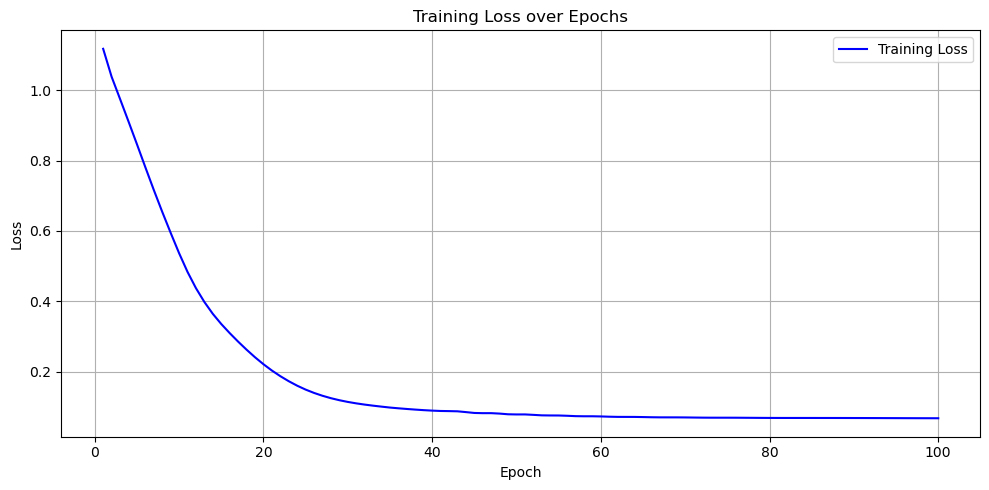

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Test loss
with torch.no_grad():
    y_pred = model(X_test)
    loss = criterion(y_pred, y_test)
    print(f"Test Loss: {loss.item()}")

Test Loss: 0.03816426545381546


In [ ]:
# Test accuracy - per item
with torch.no_grad():
    for i, data in enumerate(X_test):
        x = data
        y_pred = model(x)
        print(i + 1, " Actual:", y_test[i], " Predicted:", y_pred.max(0)[1])
        #print(f"Predicted: {torch.argmax(y_pred[i])}, Actual: {y_test[i]}")

1  Actual: tensor(1)  Predicted: tensor(1)
2  Actual: tensor(0)  Predicted: tensor(0)
3  Actual: tensor(2)  Predicted: tensor(2)
4  Actual: tensor(1)  Predicted: tensor(1)
5  Actual: tensor(1)  Predicted: tensor(1)
6  Actual: tensor(0)  Predicted: tensor(0)
7  Actual: tensor(1)  Predicted: tensor(1)
8  Actual: tensor(2)  Predicted: tensor(2)
9  Actual: tensor(1)  Predicted: tensor(1)
10  Actual: tensor(1)  Predicted: tensor(1)
11  Actual: tensor(2)  Predicted: tensor(2)
12  Actual: tensor(0)  Predicted: tensor(0)
13  Actual: tensor(0)  Predicted: tensor(0)
14  Actual: tensor(0)  Predicted: tensor(0)
15  Actual: tensor(0)  Predicted: tensor(0)
16  Actual: tensor(1)  Predicted: tensor(1)
17  Actual: tensor(2)  Predicted: tensor(2)
18  Actual: tensor(1)  Predicted: tensor(1)
19  Actual: tensor(1)  Predicted: tensor(1)
20  Actual: tensor(2)  Predicted: tensor(2)
21  Actual: tensor(0)  Predicted: tensor(0)
22  Actual: tensor(2)  Predicted: tensor(2)
23  Actual: tensor(0)  Predicted: tensor(